# Organizational Sentiment Forecasting Pipeline

This notebook demonstrates the end-to-end pipeline for generating synthetic organizational data and forecasting sentiment using an agentic approach.

### Pipeline Steps:
1. **Generate Hidden State**: Create a synthetic organization with employees, relationships, and cultural context.
2. **Encode Narrative (Optional)**: Convert the raw data into a natural language story.
3. **Generate Forecast**: Use a deterministic Python-based engine (with LLM-generated rationales) to predict sentiment propagation.
4. **Analyze & Visualize**: Explore the results, including "Public vs. Private" sentiment gaps and influence networks.


--- Visualizing Collaboration Graph ---


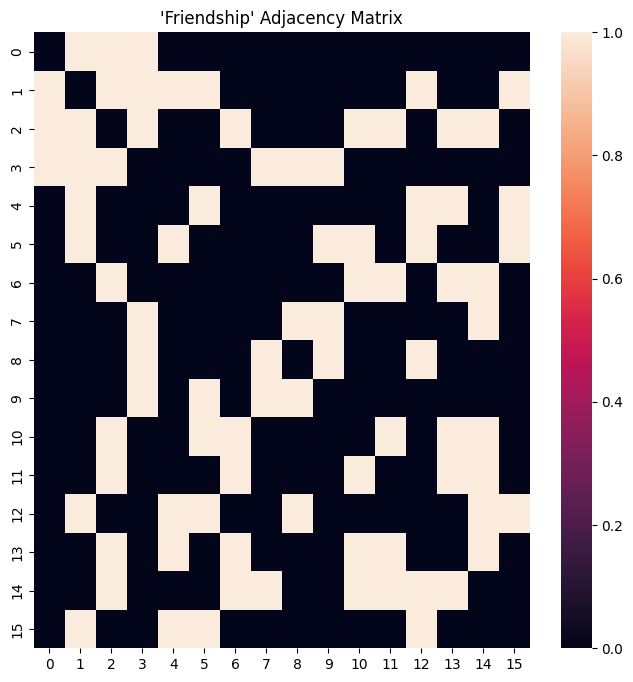

✓ Imports successful


In [1]:
import json
import os
import sys
import pandas as pd
import numpy as np
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Set random seed for reproducibility
np.random.seed(48)

# Import pipeline modules
from hidden_state_generation import (
    sample_org_seed,
    sample_rec_seed,
    sample_situation_seed,
    OrganizationHiddenState
)
from encoder_layer import create_encoded_narrative
from forward_forecaster import forecast_scenario
# Import visualization tools
from visualize_results import analyze_public_private_divergence, plot_influence_network

print("✓ Imports successful")

## 1. Generate Hidden Organizational State

We start by creating a synthetic organization. This includes:
- **Employees**: Roles, departments, tenure, personality traits (openness, performance).
- **Culture**: Values like 'past_change_success' (cynicism) and 'psychological_safety'.
- **Graphs**: Networks for reporting lines, collaboration, friendship, influence, and conflict.

In [2]:
# 1.1 Sample random seeds for the organization context
org_seed = sample_org_seed(seed=134)
rec_seed = sample_rec_seed(seed=256)
sit_seed = sample_situation_seed(seed=729)

print("Context Seeds:")
print(f"  Industry: {org_seed['industry_id']} (mapped later)")
print(f"  Change Cynicism (Past Success): {org_seed['past_change_success']:.2f}")
print(f"  Sanction Strength: {sit_seed['sanction_strength']:.2f}")

# 1.2 Generate the full hidden state
hidden_state = OrganizationHiddenState(
    org_seed=org_seed,
    rec_seed=rec_seed,
    situation_seed=sit_seed,
    departments=['Engineering', 'Marketing', 'Sales', 'HR'],
    avg_span_of_control=5
)

# Convert to dictionary for the pipeline
json_output = hidden_state.to_json_encoding()
hidden_state_dict = json.loads(json_output)

print(f"\n✓ Generated Organization: {hidden_state.N} employees")
print(f"  Departments: {list(hidden_state.employees['department'].unique())}")

# Show a sample of the employee roster
print("\nEmployee Roster (Sample):")
print(hidden_state.employees[['employee_id', 'level', 'department', 'tenure', 'performance', 'openness']].head())

Context Seeds:
  Industry: 3 (mapped later)
  Change Cynicism (Past Success): 0.30
  Sanction Strength: 0.99

✓ Generated Organization: 28 employees
  Departments: ['Sales', 'HR', 'Marketing', 'Engineering']

Employee Roster (Sample):
   employee_id     level   department  tenure  performance  openness
0            0   C-Suite        Sales       3     0.716773  0.198309
1            1  Director           HR       1     0.481105  0.354236
2            2  Director    Marketing       2     0.340751  0.364950
3            3  Director  Engineering       3     0.664225  0.726844
4            4  Director    Marketing       2     0.400642  0.543069


## 2. Encode Narrative (Optional)

We convert the structured data into a natural language narrative. This mimics the "context" an LLM would typically receive, but here we fuse it with the structured hidden state for hybrid forecasting.

In [3]:
print("Generating narrative context...")
try:
    narrative_data = create_encoded_narrative(hidden_state_dict)
    print("✓ Narrative generated successfully")
    print(f"\nScenario Preview:\n{narrative_data.get('recommendation_scenario', 'N/A')[:300]}...")
except Exception as e:
    print(f"⚠ Error generating narrative: {e}")
    narrative_data = None

Generating narrative context...
✓ Narrative generated successfully

Scenario Preview:
**Business Scenario: Navigating Compliance Challenges in a Rapidly Evolving Industry**

**Background:**

In the wake of a significant provocation event—a high-profile compliance breach by a major competitor—InnovateTech Manufacturing finds itself at a critical juncture. The breach has sent shockwave...


## 3. Generate Forecast

The core engine runs a deterministic simulation of opinion dynamics:
1. **Baseline Scores**: Calculated from individual traits (openness, performance), context (cynicism), and incentives.
2. **Network Influence**: Opinions propagate via social graphs (friendship, collaboration).
   - **Complex Contagion**: Skeptics need multiple strong supporters to switch.
   - **Opinion Leaders**: High PageRank employees have more sway.
3. **Public vs. Private**: If `safety_score` is low, dissent is suppressed (silence/compliance).
4. **Rationale**: An LLM generates a qualitative explanation of the results.

In [4]:
print("Running agentic forecast simulation...")

forecast = forecast_scenario(
    hidden_state=hidden_state_dict,
    scenario_id="demo_scenario",
    model="gpt-4o-mini",
    horizon="decision",
    narrative_context=narrative_data
)

if "error" in forecast and forecast.get("error"):
    print(f"❌ Forecast failed: {forecast.get('error_message')}")
else:
    print("✓ Forecast complete")
    
    # Print High-Level Results
    agg = forecast['aggregate_outcomes']
    print(f"\nPredicted Outcome: {agg['top_class'].upper()} ({agg['probabilities'][agg['top_class']]:.1%})")
    print(f"Rationale: {forecast.get('rationale', 'N/A')}")

Running agentic forecast simulation...
✓ Forecast complete

Predicted Outcome: SUPPORT (53.3%)
Rationale: HR leads with 58.5% support, driven by strong alignment with compliance needs, while Sales lags at 47.9%, reflecting concerns over resource allocation. Engineering and Marketing show moderate support, indicating balanced perspectives. Manager-level support is higher than Directors, suggesting grassroots engagement. C-Suite influence, particularly from Employee 0 in Sales, amplifies support across departments, aligning with InnovateTech's culture of innovation and ethical practices amidst comp...


## 4. Analyze & Visualize Dynamics

Here we uncover the hidden dynamics of the forecast, specifically the gap between **Psychological Safety** and **Public Expression**.

Analyzing Psychological Safety vs. Public Expression...

Diagnostic Info:
  Sanction Strength: 0.985
  Visibility: public
  Safety Score Range: 0.027 to 0.291
  Employees with Safety < 0.5 (gradual suppression): 28/28
  Safety Score Std Dev: 0.071 (higher = more variance)


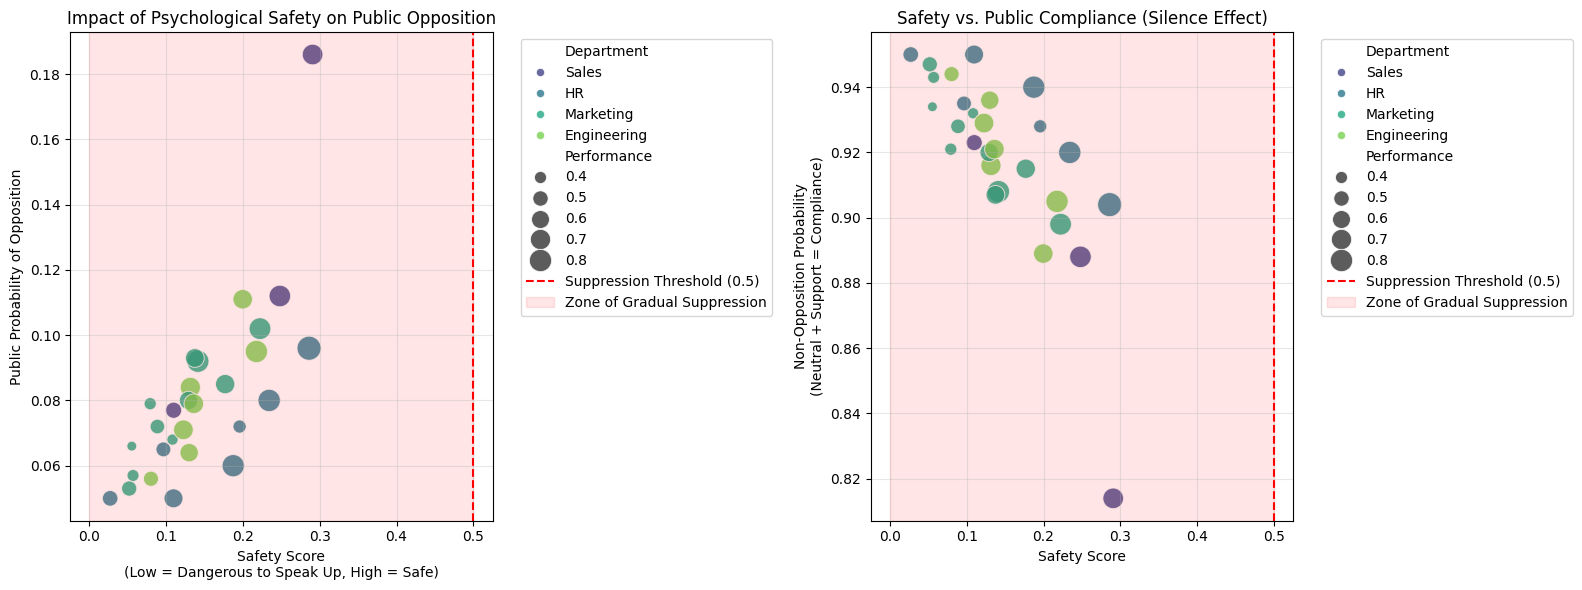


⚠ ALERT: 28 employees may be practicing 'Organizational Silence'.
They likely oppose privately but feel unsafe to speak up.
    Employee ID   Department  Safety Score  Public Oppose  \
0             0        Sales      0.290697          0.186   
1             1           HR      0.096430          0.065   
2             2    Marketing      0.055288          0.066   
3             3  Engineering      0.199678          0.111   
4             4    Marketing      0.079245          0.079   
5             5           HR      0.195638          0.072   
6             6  Engineering      0.129960          0.064   
7             7    Marketing      0.222192          0.102   
8             8           HR      0.027093          0.050   
9             9    Marketing      0.108307          0.068   
10           10    Marketing      0.141311          0.092   
11           11    Marketing      0.056886          0.057   
12           12    Marketing      0.051875          0.053   
13           13    Ma

In [5]:
# 4.1 Public vs. Private Sentiment Gap
# This plot shows how low safety scores (x-axis) lead to suppressed opposition (y-axis).

print("Analyzing Psychological Safety vs. Public Expression...")
df_analysis = analyze_public_private_divergence(hidden_state_dict, forecast)

# Identify "Silenced" Employees
# Those with Low Safety (< 0.5, where gradual suppression occurs) but who are complying (High Non-Opposition)
silenced = df_analysis[
    (df_analysis['Safety Score'] < 0.5) & 
    (df_analysis['Non-Opposition (Compliance)'] > 0.5)
]

if not silenced.empty:
    print(f"\n⚠ ALERT: {len(silenced)} employees may be practicing 'Organizational Silence'.")
    print("They likely oppose privately but feel unsafe to speak up.")
    print(silenced[['Employee ID', 'Department', 'Safety Score', 'Public Oppose', 'Non-Opposition (Compliance)']])
else:
    print("\nNo significant organizational silence detected in this scenario.")

Visualizing Influence Network...


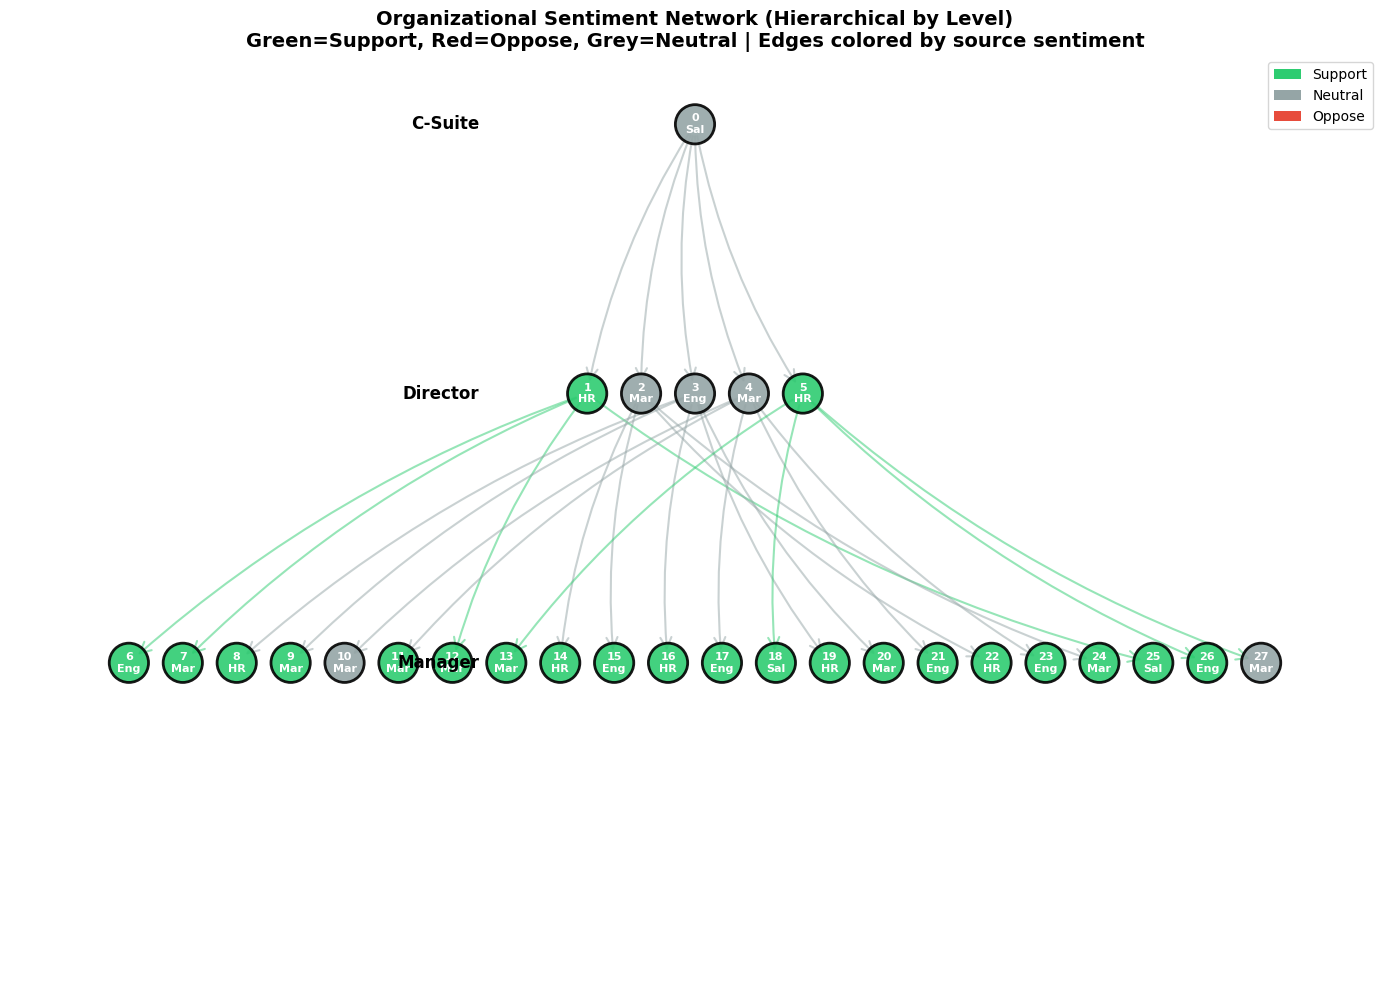

In [6]:
# 4.2 Influence Network
# Visualize how sentiment clusters in the network. 
# Green = Support, Red = Oppose, Grey = Neutral

print("Visualizing Influence Network...")
plot_influence_network(hidden_state_dict, forecast)

In [7]:
# 4.3 Detailed Probability Breakdown
print("Detailed Forecast Breakdown (Top 10 Employees):")
df_probs = pd.DataFrame([
    {
        'ID': s['employee_id'],
        'Sentiment': s['sentiment'],
        'Oppose': s['probabilities']['oppose'],
        'Neutral': s['probabilities']['neutral'],
        'Support': s['probabilities']['support']
    } 
    for s in forecast['individual_sentiments']
])

print(df_probs.head(10))

Detailed Forecast Breakdown (Top 10 Employees):
   ID Sentiment  Oppose  Neutral  Support
0   0   support   0.186    0.398    0.416
1   1   support   0.065    0.397    0.538
2   2   support   0.066    0.439    0.495
3   3   support   0.111    0.395    0.494
4   4   support   0.079    0.442    0.479
5   5   support   0.072    0.343    0.585
6   6   support   0.064    0.369    0.567
7   7   support   0.102    0.371    0.527
8   8   support   0.050    0.371    0.579
9   9   support   0.068    0.394    0.538
